    author: Roman Makarov
    e-mail: mcronomus@gmail.com

#CNN for Triple MNIST classification

####Data preparation and creation of data loaders

In [1]:
!gdown 1DtWT_0JuLzvAoysUcH0j5mbcVFL7Y45T

Downloading...
From: https://drive.google.com/uc?id=1DtWT_0JuLzvAoysUcH0j5mbcVFL7Y45T
To: /content/triple_mnist.zip
100% 85.7M/85.7M [00:00<00:00, 115MB/s] 


In [2]:
%%capture
!unzip triple_mnist.zip

In [3]:
import torch
from torch.utils import data
from torchvision import datasets, transforms

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

img_path = 'triple_mnist'

class ImageDataset(Dataset):
  def __init__(self, img_path, transform, to_perform=False, transform_2=-1):
    self.path = img_path
    self.folder = [x for x in os.listdir(img_path)]

    self.images = []
    for x in self.folder:
        for y in os.listdir(img_path + '/' + x):
            self.images.append((img_path + '/' + x + '/' + y, 0))

            if type(transform_2) is not int:
                self.images.append((img_path + '/' + x + '/' + y, 1))

    self.transform = transform
    self.transform_2 = transform_2

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_loc = self.images[idx][0]
    type_ = self.images[idx][1]

    image = Image.open(img_loc).convert('RGB')

    if type_ == 0 or type(self.transform_2) is int:
        single_img = self.transform(image)
    else:
        single_img = self.transform_2(image)

    general_label = self.images[idx][0].split('/')[-1].split('.')[0].split('_')[-1]

    label1 = int(general_label[0])
    label2 = int(general_label[1])
    label3 = int(general_label[2])

    sample = {'image':single_img, 'labels': {0:label1, 1:label2, 2:label3}}

    return sample

In [5]:
def imshow(inp):
    inp = inp.numpy()[0]
    mean = 0.1307
    std = 0.3081
    inp = inp * std + mean
    plt.imshow(inp, cmap='gray')
    plt.show()

In [6]:
batch_size_train = 128
batch_size_test = 128
batch_size_val = 128

data_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor()])

data_transforms_train = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                            transforms.RandomRotation(15),
                                            transforms.Resize((84, 84)),
                                            transforms.ToTensor()])
train_dataset = ImageDataset(img_path + '/train', data_transforms, True, data_transforms_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True,
                                num_workers=2)

test_dataset = ImageDataset(img_path + '/test', data_transforms, False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True,
                               num_workers=2)

val_dataset = ImageDataset(img_path + '/val', data_transforms, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True,
                               num_workers=2)

####Creating CNN model and testing it on dataset

In [7]:
from time import time
import numpy as np

def train(model, device, epochs, train_loader, loss_func):
    n_total_steps = len(train_loader)
    start_time = time()

    correct = 0
    all = 0

    for i, pictures in enumerate(train_loader):
        images = pictures['image'].to(device)

        outputs = model(images).to(device)

        loss = 0
        correct_cur = np.zeros((outputs.shape[0], 3))

        for ii in range(3):
            outputs_i = outputs[:, ii * 10 : (ii + 1) * 10]
            pred = outputs_i.argmax(dim=1, keepdim=True).to(device)

            correct_pred = pred.eq(pictures['labels'][ii].view_as(pred).to(device)).cpu().detach().numpy().astype(int)
            for j in range(outputs.shape[1]):
                correct_cur[j][ii] += correct_pred[j]
                if ii == 2 and correct_cur[j].sum() == 3:
                    correct += 1

            loss += loss_func(outputs[:, ii * 10 : (ii + 1) * 10], pictures['labels'][ii].to(device)).to(device)

        all += outputs.shape[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 20 == 0:
            print(f'\rTrain Epoch [{epoch}],',
                    f'Step [{i + 1}/{n_total_steps}],',
                    f'Loss: {loss:.2f},',
                    f'Accuracy: {100. * correct / all:.2f}%',
                    f'elapsed time: {time() - start_time:.2f}s',
                    end='')
    print()

def test(model, device, test_loader, loss_func, type_of_test='Test'):
    model.eval()
    test_loss = 0
    correct = 0
    all = 0

    with torch.no_grad():
        for i, pictures in enumerate(test_loader):
            images = pictures['image'].to(device)
            pictures = pictures

            outputs = model(images)

            correct_cur = np.zeros((outputs.shape[0], 3))

            for ii in range(3):
                outputs_i = outputs[:, ii * 10 : (ii + 1) * 10]
                pred = outputs_i.argmax(dim=1, keepdim=True)

                correct_pred = pred.eq(pictures['labels'][ii].view_as(pred).to(device)).cpu().detach().numpy().astype(int)
                for j in range(outputs.shape[1]):
                    correct_cur[j][ii] += correct_pred[j]
                    if ii == 2 and correct_cur[j].sum() == 3:
                        correct += 1

                test_loss += loss_func(outputs[:, ii * 10 : (ii + 1) * 10], pictures['labels'][ii].to(device))

            all += outputs.shape[1]

    test_loss /= len(test_loader.dataset)

    print(f'{type_of_test} set: Average loss: {test_loss:.2f}, Accuracy: {100. * correct / all:.2f}%')

    return 100. * correct / all

####Model with 3 convolutional layers

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_digits=10):
        super().__init__()

        self.general = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(24),
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(24),
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(12),
        )

        self.label = nn.Sequential(
            nn.Linear(in_features = 10 * 10 * 12, out_features = 64),
            nn.Dropout(p=0.2),
            nn.Linear(in_features = 64, out_features = n_digits * 3)
        )

    def forward(self, x):
        x = self.general(x)
        x = torch.flatten(x, 1)
        x = self.label(x)
        return x

In [9]:
batch_size_train = 128
batch_size_test = 128
batch_size_val = 128

data_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor()])

data_transforms_train = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                            transforms.RandomRotation(15),
                                            transforms.Resize((84, 84)),
                                            transforms.ToTensor()])

train_dataset = ImageDataset(img_path + '/train', data_transforms, True, data_transforms_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True,
                                num_workers=2)

test_dataset = ImageDataset(img_path + '/test', data_transforms, False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True,
                               num_workers=2)

val_dataset = ImageDataset(img_path + '/val', data_transforms, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True,
                               num_workers=2)

import torch.optim as optim

lr = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

epoch_nums = []
validation_loss = []
current_count = 0

epochs = 10
print('Training on:', device, '\n')
for epoch in range(1, epochs + 1):
        train(model=model, device=device, train_loader=train_loader, epochs=epoch, loss_func=loss_func)

        test_accuracy = test(model=model, device=device, test_loader=test_loader, loss_func=loss_func)

        if epoch > 1:
            if test_accuracy - validation_loss[-1] < 0.5:
                current_count += 1
            else:
                current_count = 0

        epoch_nums.append(epoch)
        validation_loss.append(test_accuracy)

        if current_count > 1:
            print(f'Early stopping on epoch: {epoch}')
            break

print('\nProceeding to validation...')
val_acc = test(model=model, device=device, test_loader=val_loader, loss_func=loss_func, type_of_test='Validation')

Training on: cuda 

Train Epoch [1], Step [1000/1000], Loss: 0.46, Accuracy: 76.77% elapsed time: 65.18s
Test set: Average loss: 0.01, Accuracy: 66.77%
Train Epoch [2], Step [1000/1000], Loss: 0.15, Accuracy: 88.26% elapsed time: 51.68s
Test set: Average loss: 0.00, Accuracy: 91.89%
Train Epoch [3], Step [1000/1000], Loss: 0.27, Accuracy: 92.80% elapsed time: 51.48s
Test set: Average loss: 0.00, Accuracy: 93.27%
Train Epoch [4], Step [1000/1000], Loss: 0.17, Accuracy: 93.48% elapsed time: 51.68s
Test set: Average loss: 0.00, Accuracy: 93.08%
Train Epoch [5], Step [1000/1000], Loss: 0.12, Accuracy: 93.96% elapsed time: 52.13s
Test set: Average loss: 0.00, Accuracy: 94.54%
Train Epoch [6], Step [1000/1000], Loss: 0.20, Accuracy: 94.16% elapsed time: 51.79s
Test set: Average loss: 0.00, Accuracy: 94.25%
Train Epoch [7], Step [1000/1000], Loss: 0.15, Accuracy: 94.26% elapsed time: 52.10s
Test set: Average loss: 0.00, Accuracy: 93.99%
Early stopping on epoch: 7

Proceeding to validation...


####Demonstrating an example

Label= 581
Predicted label 581


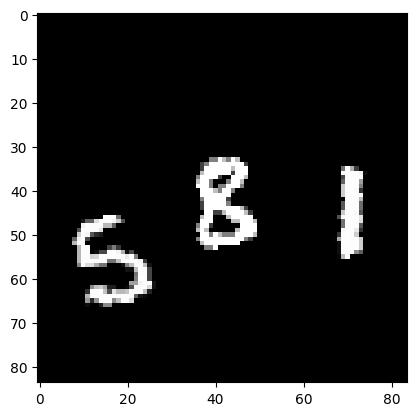

In [10]:
import matplotlib.pyplot as plt
res = next(iter(train_loader))
images = res['image'].to(device)
labels = res['labels']

def get_label(labels, idx):
    return f"{labels[0][idx].item()}{labels[1][idx].item()}{labels[2][idx].item()}"

print('Label=', get_label(labels, 0))

predict = model(images)[0]
p_v = []
for i in range(3):
    predict_i = predict[i * 10 : (i + 1) * 10]
    pred = predict_i.argmax(dim=0, keepdim=True)
    p_v.append(pred.item())

print(f'Predicted label {p_v[0]}{p_v[1]}{p_v[2]}')

imshow(images[0].cpu())

####Measuring time taken to predict 50 samples

In [11]:
from time import time

def measure(model, device, test_loader, task_n=1):
    model.eval()
    test_loss = 0
    correct = 0
    all = 0

    start = time()
    with torch.no_grad():
        for i, pictures in enumerate(test_loader):
            images = pictures['image'].to(device)
            pictures = pictures

            outputs = model(images)
            break

    end = time()
    print(f'Time to predict 50 samples for CNN model: {end - start:.2f}s')

In [12]:
batch_size_train = 50

data_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor()])

measure_dataset = ImageDataset(img_path + '/train', data_transforms, False)

measure_loader = DataLoader(measure_dataset, batch_size=batch_size_train, shuffle=True,
                                num_workers=2)

import torch.optim as optim

lr = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

epoch_nums = []
validation_loss = []
current_count = 0

measure(model=model, device=device, test_loader=measure_loader, task_n=2)

Time to predict 50 samples for CNN model: 0.24s
